In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seed = sum(map(ord, "Posterior Predictive"))
rng = np.random.default_rng(seed)

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')

### Columns description
* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [10]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


<Axes: >

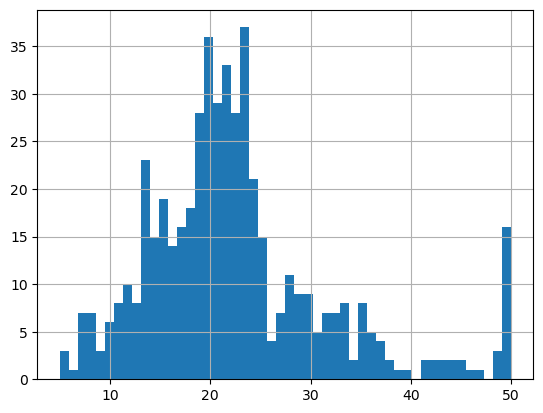

In [15]:
df.medv.hist(bins=50)

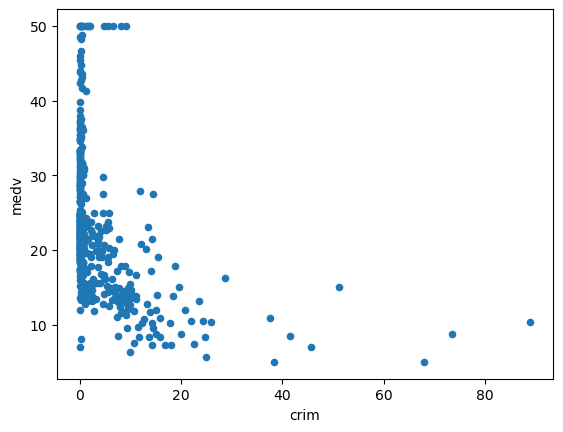

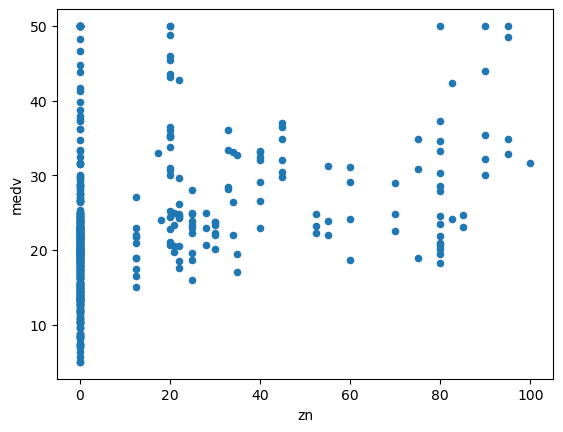

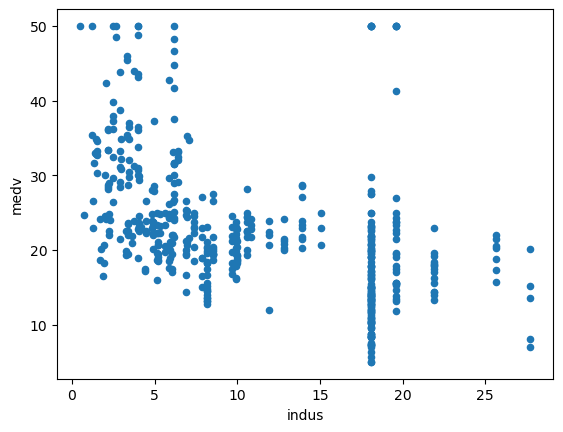

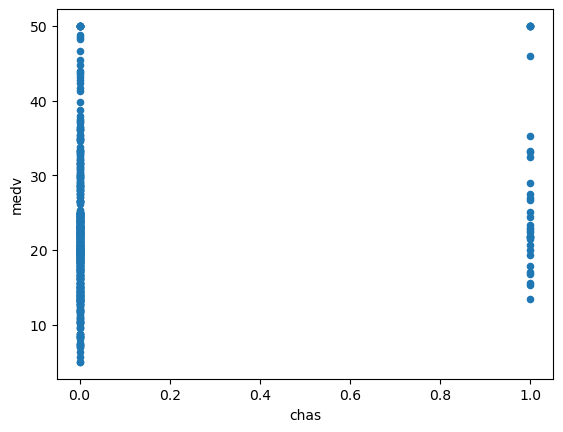

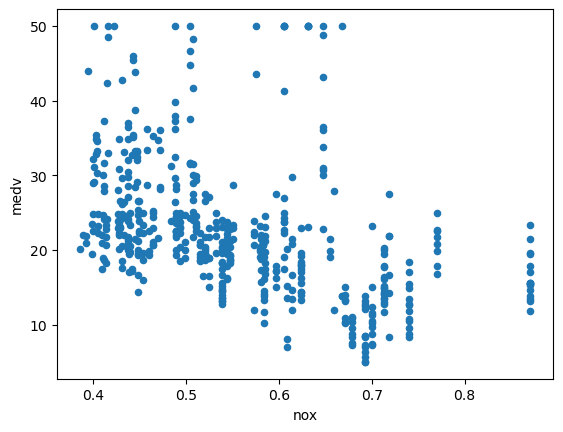

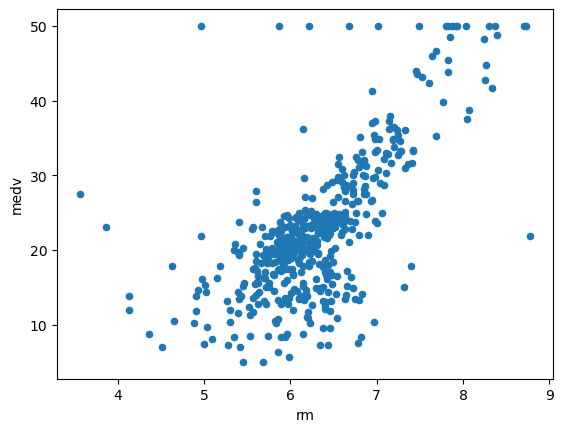

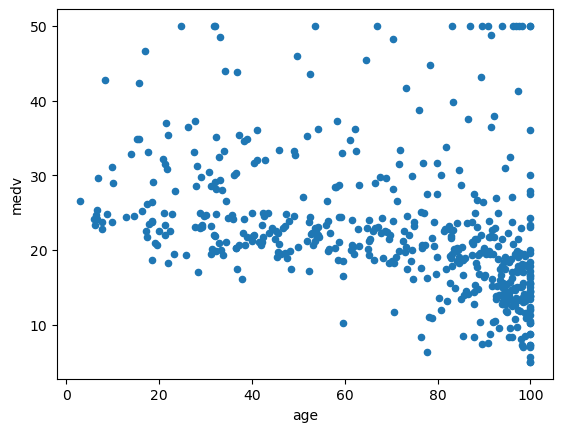

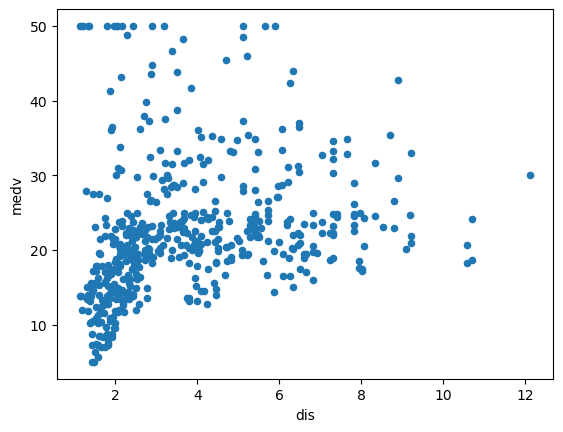

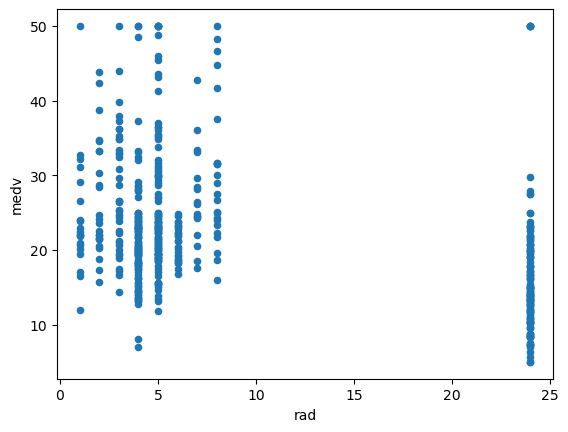

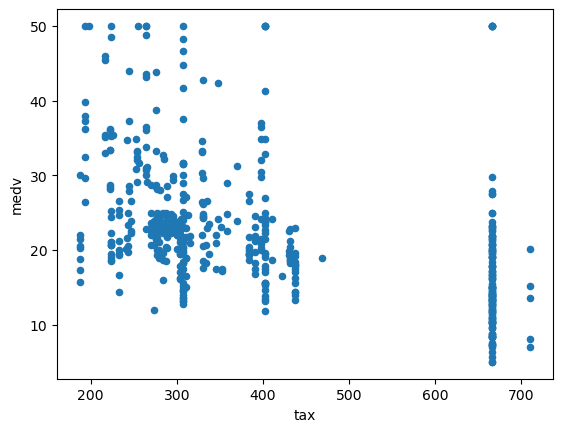

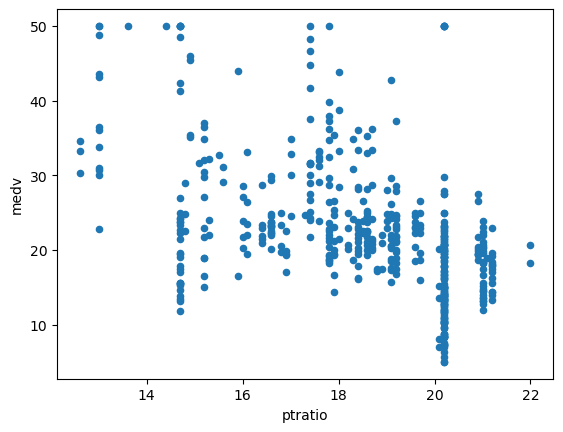

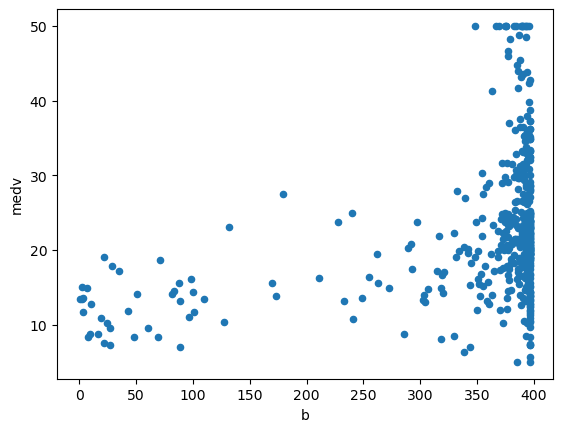

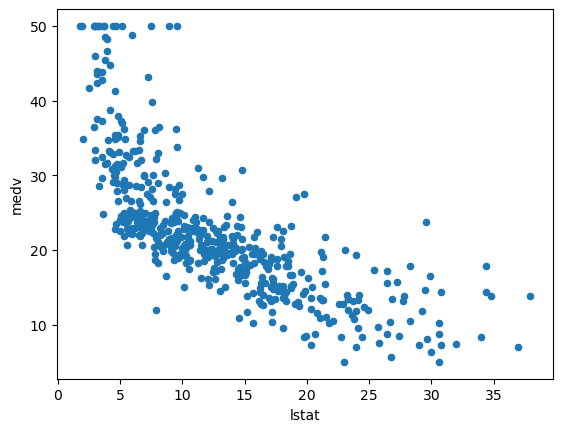

In [18]:
for c in df.columns:
    if c not in ('medv'):
        df.plot.scatter(x=c, y='medv')
        plt.show()

### Objective 1
Model MEDV in function of LSTAT

In [23]:
df.medv.mean()

22.532806324110677

In [51]:
with pm.Model() as m:
    
    x = pm.MutableData("x", df.lstat.values)
    y_obs = df.medv.values

    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    y = pm.Normal("y", mu=a * x + b, sigma=sigma, observed=y_obs)

    idata = pm.sample(random_seed=rng)


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [52]:
m

    a ~ Normal(0, 1)
    b ~ Normal(0, 1)
sigma ~ HalfNormal(0, 1)
    y ~ Normal(f(b, a), sigma)

Sampling: [a, b, sigma, y]


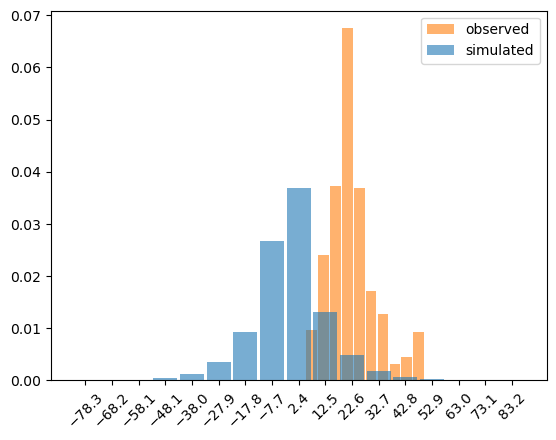

In [53]:
with m:
    prior_samples = pm.sample_prior_predictive(100)

az.plot_dist(
    y_obs,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["y"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
_ = plt.xticks(rotation=45)

In [54]:
with m:
    idata = pm.sample(1000, tune=2000, random_seed=seed)  #, target_accept=0.99

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.


Sampling: [y]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

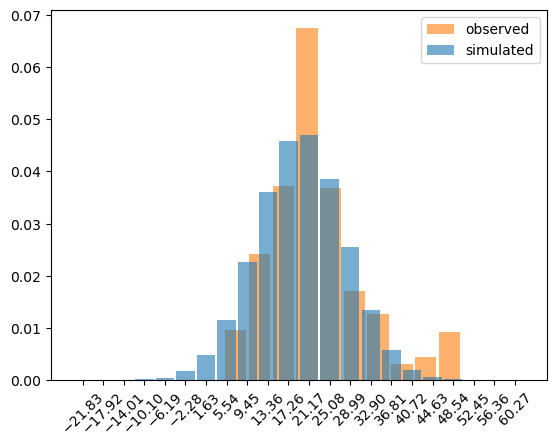

In [55]:
with m:
    posterior_samples = pm.sample_posterior_predictive(idata)

az.plot_dist(
    y_obs,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    posterior_samples.posterior_predictive["y"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
_ = plt.xticks(rotation=45)

In [56]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.222,0.059,-0.327,-0.108,0.002,0.001,1127.0,1790.0,1.0
b,22.422,0.896,20.732,24.073,0.027,0.019,1110.0,1649.0,1.0
sigma,8.125,0.344,7.474,8.781,0.010,0.007,1170.0,1455.0,1.0


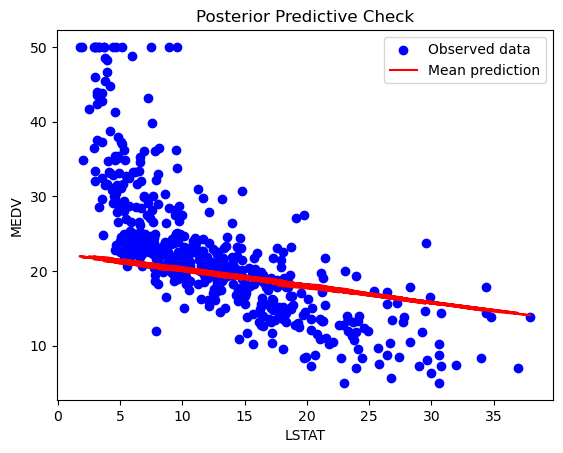

In [89]:
# Assuming `idata` is your inference data from the model
# Extract posterior predictive samples
posterior_predictive = az.extract(posterior_samples, group="posterior_predictive")

# Calculate the mean and credible intervals
y_pred = posterior_predictive["y"]
y_mean = np.mean(y_pred, axis=1)
y_hdi = az.hdi(y_pred, hdi_prob=0.95, on_missing_core_dim='copy')

# Plot the observed data
plt.scatter(df.lstat.values, df.medv.values, color='blue', label='Observed data')

# Plot the mean predictions
plt.plot(df.lstat.values, y_mean, color='red', label='Mean prediction')


# Plot the credible intervals
plt.fill_between(df.lstat.values, y_hdi['y'][:, 0], y_hdi['y'][:, 1], color='red', alpha=0.3, label='95% credible interval')

# Add labels and legend
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.legend()
plt.title('Posterior Predictive Check')
plt.show()

In [82]:
y_pred

<xarray.DataArray 'y' (y_dim_2: 506, sample: 4000)> Size: 16MB
array([[37.69524378, 20.44040029, 15.49887214, ..., 34.41663843,
        16.29947225, 15.55275118],
       [21.44636905, 33.86982665, 16.48778744, ..., 14.376289  ,
        16.30884608, 16.19799675],
       [29.10682788, 29.24129142,  8.96550865, ..., 16.6287355 ,
        31.23576496, 25.72696228],
       ...,
       [14.21909166, 28.8098509 , 21.51478793, ..., 24.57754824,
        11.03447227, 37.92181795],
       [10.49842866, 27.71010863, 20.50983325, ..., 25.94538383,
        30.10617442, 21.49534885],
       [31.60668201, 25.06899521, 20.8992537 , ..., 21.02071807,
        22.8315857 , 25.56790561]])
Coordinates:
  * y_dim_2  (y_dim_2) int32 2kB 0 1 2 3 4 5 6 7 ... 499 500 501 502 503 504 505
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int32 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999